In [3]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

db = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='Sameer@2003',
    database='bank'
)

# Create a cursor
cur = db.cursor()

In [4]:
query = """ select * from churn_data """
cur.execute(query)
data = cur.fetchall()                               
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,City,Gender,Age,TotalWork,Balance,NumofAccounts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101349.0,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543.0,0
2,3,15619304,Onio,502,France,Female,42,8,159661.0,3,1,0,113932.0,1
3,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125511.0,1,1,1,79084.1,0


# 1. What is the overall customer retention and churn rate?

Where:
   Exited = 1 → Customer churned, 
   Exited = 0 → Customer retained

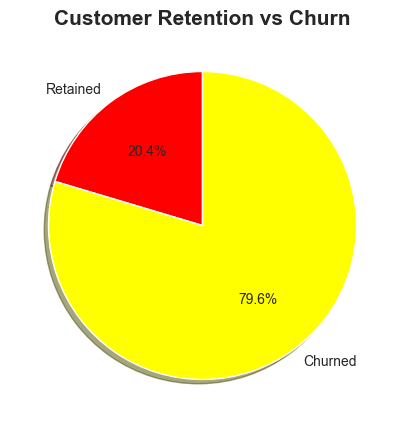

In [62]:
query = """ SELECT Exited, 
                   COUNT(*) AS Total_customers,
	               ROUND(COUNT(*)*100 / (SELECT COUNT(*) FROM churn_data), 2) AS Percentage
            FROM churn_data
            GROUP BY Exited """
cur.execute(query)
data = cur.fetchall()                              
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df.head()

x = df['Percentage']
y = ['Retained', 'Churned']
color = ['Red','Yellow']

plt.figure(figsize=(5,5))
plt.pie(x, labels = y, colors = color, shadow = True, autopct='%1.1f%%', startangle=90)
plt.title('Customer Retention vs Churn',fontsize=15,fontweight='bold')
plt.show()

# 2. Which customer segments have the highest churn rates?

In [6]:
query = """ SELECT 
                City,
                Gender,
                COUNT(*) AS Total_customers,
                SUM(Exited) AS Churned_customers,
                ROUND(SUM(Exited)*100 / COUNT(*),2) AS Churn_Rate_Percentage
            FROM churn_data
            GROUP BY City, Gender
            ORDER BY Churn_Rate_Percentage DESC """
cur.execute(query)
data = cur.fetchall()                                
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df.head(10)

,City,Gender,Total_customers,Churned_customers,Churn_Rate_Percentage
0,Germany,Female,1193,448,37.55
1,Germany,Male,1317,367,27.87
2,Spain,Female,1089,231,21.21
3,France,Female,2262,460,20.34
4,Spain,Male,1388,182,13.11
5,France,Male,2753,350,12.71


# 3. What are the average customer characteristics for churned vs. retained customers ?

In [7]:
query = """ SELECT 
               Exited,
               ROUND(AVG(Age),2) AS avg_age,
               ROUND(AVG(Balance),2) AS avg_balance,
               ROUND(AVG(EstimatedSalary),2) AS avg_salary,
               ROUND(AVG(TotalWork),2) AS avg_totalwork,
               ROUND(AVG(HasCrCard),2) AS credit_card_ownership_rate
            FROM churn_data
            GROUP BY Exited """
cur.execute(query)
data = cur.fetchall()                               
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df.head()

,Exited,avg_age,avg_balance,avg_salary,avg_totalwork,credit_card_ownership_rate
0,1,44.84,91100.67,101461.47,4.93,0.70
1,0,37.41,72752.50,99730.66,5.03,0.71


# 4. How does tenure (length of work in years) affect customer churn?

In [92]:
query = """ SELECT 
                TotalWork,
                COUNT(*) AS Total_customers,
                SUM(Exited) AS Churned_customers,
                ROUND(SUM(Exited)*100/ COUNT(*), 2) AS Churn_Rate_Percentage
            FROM churn_data
            GROUP BY TotalWork
            ORDER BY TotalWork """
cur.execute(query)
data = cur.fetchall()                               
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df.head(15)

,TotalWork,Total_customers,Churned_customers,Churn_Rate_Percentage
0,0,413,95,23.00
1,1,1035,232,22.42
2,2,1048,201,19.18
3,3,1010,214,21.19
4,4,990,203,20.51
5,5,1012,209,20.65
6,6,967,196,20.27
7,7,1028,177,17.22
8,8,1025,197,19.22
9,9,984,213,21.65


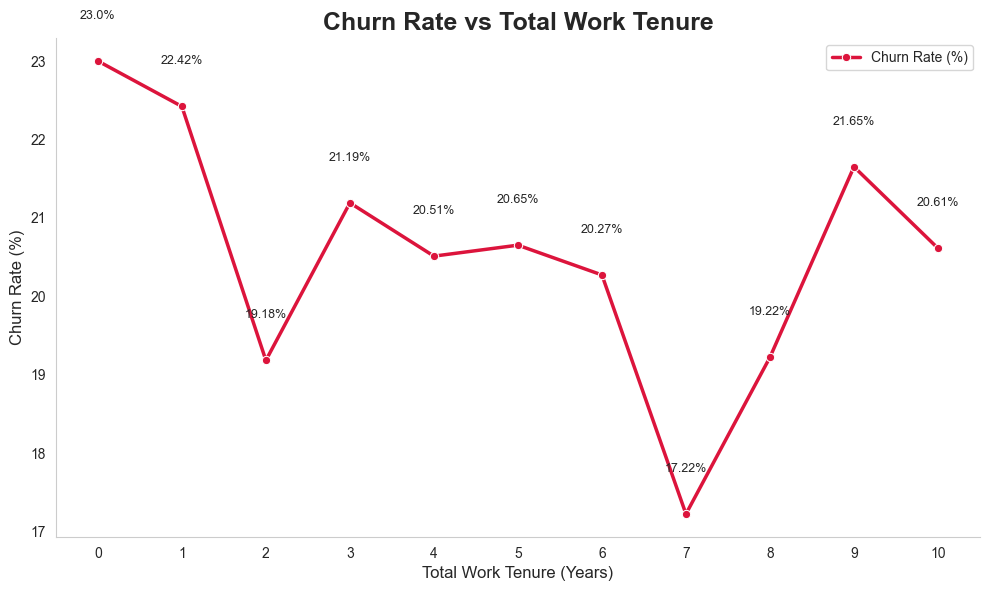

In [93]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='TotalWork',
    y='Churn_Rate_Percentage',
    marker='o',
    label='Churn Rate (%)',
    color='crimson',
    linewidth=2.5
)
for x, y in zip(df['TotalWork'], df['Churn_Rate_Percentage']):
    plt.text(x, float(y) + 0.5, f"{float(y)}%", ha='center', va='bottom', fontsize=9)
# Aesthetics
plt.title('Churn Rate vs Total Work Tenure', fontsize=18,fontweight='bold')
plt.xlabel('Total Work Tenure (Years)', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(df['TotalWork'])  # Ensure x-axis matches all TotalWork years         
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

# 5. How many customers use additional services like credit cards or active memberships?

In [53]:
query = """ SELECT 
                'Credit Card User' AS Service_Type,
                 HasCrCard AS Status,
                 COUNT(*) AS Total_Customers
            FROM churn_data
            GROUP BY HasCrCard
            UNION ALL
            SELECT 
                 'Active Member' AS Service_Type,
                 IsActiveMember AS Status,
                 COUNT(*) AS Total_Customers
            FROM churn_data
            GROUP BY IsActiveMember """
cur.execute(query)
data = cur.fetchall()                               
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df.head()

,Service_Type,Status,Total_Customers
0,Credit Card User,1,7057
1,Credit Card User,0,2945
2,Active Member,1,5151
3,Active Member,0,4851


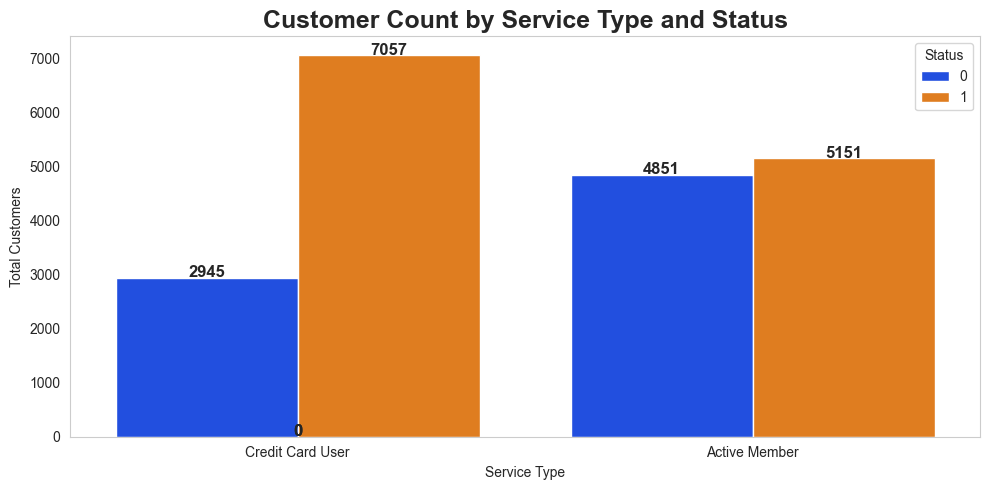

In [54]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='Service_Type', y='Total_Customers', hue='Status', palette='bright')

# Show value labels on bar
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5, int(height), ha='center', fontsize=12,fontweight='bold')

plt.title('Customer Count by Service Type and Status',fontsize=18,fontweight='bold')
plt.xlabel('Service Type')
plt.ylabel('Total Customers')
plt.tight_layout()
plt.grid(False)
plt.show()

# 6. What factors most strongly correlate with customer churn?

In [55]:
query = """ SELECT 
                CASE 
                  WHEN Balance < 10000 THEN 'Low Balance'
                  WHEN Balance BETWEEN 10000 AND 50000 THEN 'Medium Balance'
                  ELSE 'High Balance'
                END AS balance_group,
                CASE
                  WHEN EstimatedSalary < 50000 THEN 'Low Salary'
                  WHEN EstimatedSalary BETWEEN 50000 AND 100000 THEN 'Medium Salary'
                  ELSE 'High Salary'
                END AS salary_group,
                ROUND(AVG(Exited)*100, 2) AS churn_rate_percentage,
                COUNT(*) AS total_customers
             FROM churn_data
             GROUP BY balance_group, salary_group
             ORDER BY balance_group, salary_group """
cur.execute(query)
data = cur.fetchall()                               
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df

,balance_group,salary_group,churn_rate_percentage,total_customers
0,High Balance,High Salary,24.25,3192
1,High Balance,Low Salary,24.08,1524
2,High Balance,Medium Salary,23.27,1594
3,Low Balance,High Salary,14.42,1782
4,Low Balance,Low Salary,12.90,915
5,Low Balance,Medium Salary,13.68,921
6,Medium Balance,High Salary,36.11,36
7,Medium Balance,Low Salary,26.67,15
8,Medium Balance,Medium Salary,34.78,23


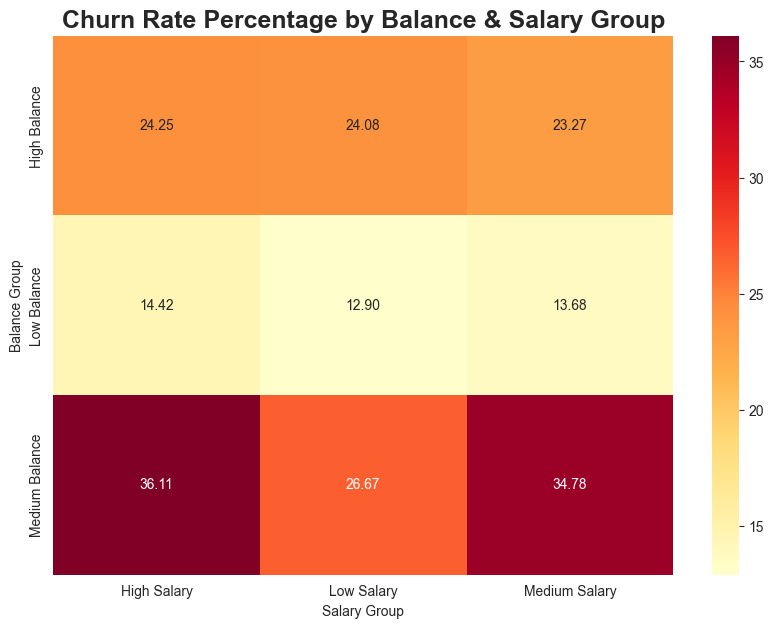

In [56]:
heatmap_data = df.pivot(index='balance_group', columns='salary_group', values='churn_rate_percentage')

# Fix non-numeric or missing data
heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce').fillna(0)
plt.figure(figsize=(10,7))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title('Churn Rate Percentage by Balance & Salary Group',fontsize=18,fontweight='bold')
plt.xlabel('Salary Group')
plt.ylabel('Balance Group')
plt.show()

# 7. Which age groups have higher churn?

In [39]:
query = """ SELECT
                CASE
                   WHEN Age < 30 THEN 'Under 30'
                   WHEN Age BETWEEN 30 AND 45 THEN '30-45'
                   WHEN Age BETWEEN 46 AND 60 THEN '46-60'
                ELSE '60+'
                END AS age_group,
                ROUND(AVG(Exited)*100, 2) AS churn_rate_percentage,
                COUNT(*) AS total_customers
            FROM churn_data
            GROUP BY age_group
            ORDER BY churn_rate_percentage ASC """
cur.execute(query)
data = cur.fetchall()                                
columns = [desc[0] for desc in cur.description]    
df = pd.DataFrame(data, columns=columns)
df.head()

,age_group,churn_rate_percentage,total_customers
0,Under 30,7.56,1641
1,30-45,15.31,6250
2,60+,24.78,464
3,46-60,51.12,1647


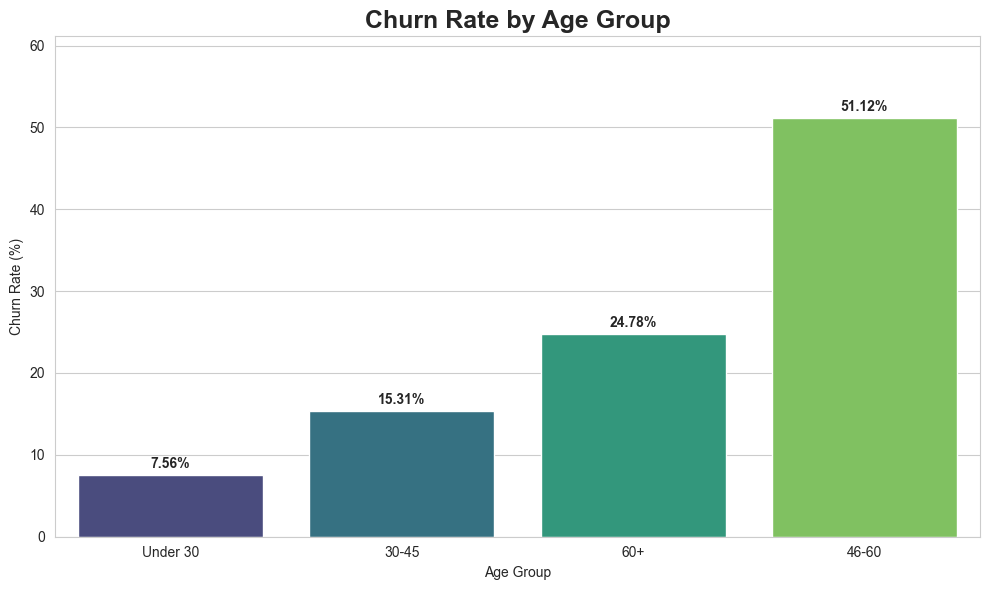

In [42]:
df['churn_rate_percentage'] = pd.to_numeric(df['churn_rate_percentage'], errors='coerce')
df['age_group'] = df['age_group'].astype(str)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='age_group', y='churn_rate_percentage', hue='age_group', data=df, palette='viridis')

# Add data labels
for i, row in df.iterrows():
    ax.text(i, row['churn_rate_percentage'] + 0.5, f"{row['churn_rate_percentage']}%", 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Churn Rate by Age Group',fontsize=18,fontweight='bold')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, df['churn_rate_percentage'].max() + 10)  # Adjust Y-axis to fit labels
plt.tight_layout()
plt.show()


# 8. What customer profile has the highest Lifetime Value (LTV)?

LTV = Balance × Tenure(TotalWork) × Active status (or estimated retention probability).

In [16]:
query = """ SELECT
                City,
              CASE
                WHEN Age < 30 THEN 'Young'
                WHEN Age BETWEEN 30 AND 50 THEN 'Middle Age'
              ELSE 'Senior'
              END AS Age_group,
              NumofAccounts,
              ROUND(AVG(balance * totalwork * isactivemember), 2) AS avg_ltv,
              ROUND(SUM(exited) * 100.0 / COUNT(*), 2) AS churn_rate_percent,
              COUNT(*) AS total_customers
            FROM churn_data
            GROUP BY City, age_group, NumofAccounts
            ORDER BY avg_ltv DESC """
cur.execute(query)
data = cur.fetchall()                                
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df

,City,Age_group,NumofAccounts,avg_ltv,churn_rate_percent,total_customers
0,Germany,Senior,2,453339.26,32.35,102
1,Germany,Middle Age,4,408439.83,100.00,18
2,France,Senior,4,333190.15,100.00,8
3,Spain,Young,1,316751.32,10.47,172
4,Germany,Young,1,316445.26,17.10,193
5,Germany,Middle Age,2,309820.66,11.20,768
6,Spain,Senior,1,309017.08,39.66,174
7,Germany,Senior,1,304271.85,67.26,226
8,Germany,Young,3,293925.72,71.43,7
9,Germany,Middle Age,3,276527.56,87.88,66


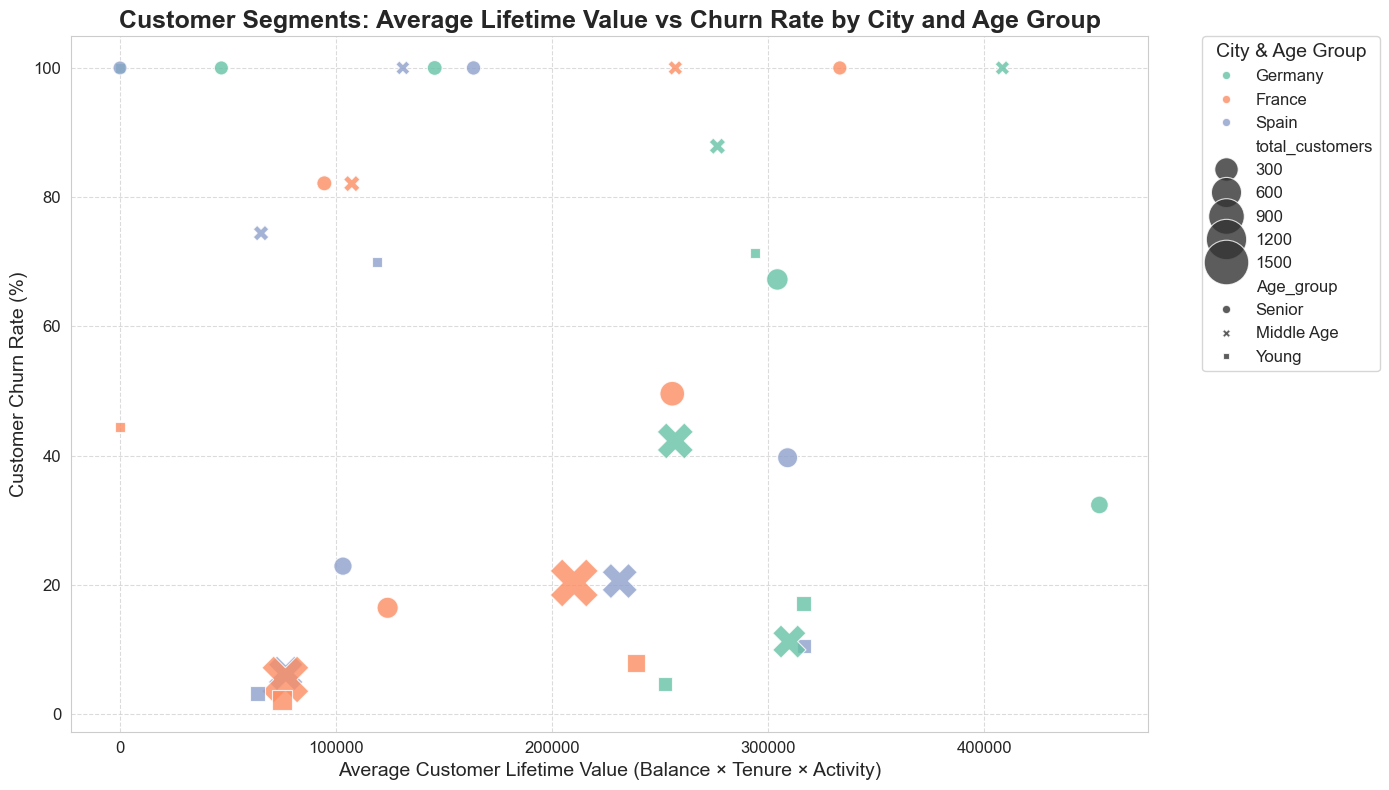

In [17]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df,
    x='avg_ltv',
    y='churn_rate_percent',
    size='total_customers',
    hue='City',
    style='Age_group',
    sizes=(100, 1200),
    alpha=0.8,
    palette='Set2'
)
plt.title('Customer Segments: Average Lifetime Value vs Churn Rate by City and Age Group', fontsize=18, weight='bold')
plt.xlabel('Average Customer Lifetime Value (Balance × Tenure × Activity)', fontsize=14)
plt.ylabel('Customer Churn Rate (%)', fontsize=14)

# Improve legend appearance
handles, labels = scatter.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],  # skip the first handle as it's for size title
    labels=labels[1:],
    title='City & Age Group',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize=12,
    title_fontsize=14
)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



#### This chart shows different customer groups based on their value to us (from how much they use and stay with our bank) and how likely they are to leave.

#### On the bottom (X-axis), we have ‘Average Lifetime Value’ — it means how much profit a customer can give us.

#### On the left side (Y-axis), we have ‘Churn Rate’ — how many of them are leaving us.

#### Each circle is a group of customers. Big circles mean more customers in that group.

#### Colors show cities like Germany, France, Spain, etc., and shapes show age group like Young, Middle Age, and Senior.

# 9. What is the relationship between the number of products a customer holds and their likelihood to churn across different cities?

In [71]:
query = """ SELECT
                City,
                NumOfAccounts,
                COUNT(*) AS total_customers,
                SUM(Exited) AS total_churned,
                ROUND(SUM(Exited) * 100/ COUNT(*), 2) AS churn_rate_percent
            FROM churn_data
            GROUP BY City, NumOfAccounts
            ORDER BY City, NumOfAccounts """
cur.execute(query)
data = cur.fetchall()                              
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df

,City,NumOfAccounts,total_customers,total_churned,churn_rate_percent
0,France,1,2515,564,22.43
1,France,2,2367,135,5.70
2,France,3,104,82,78.85
3,France,4,29,29,100.00
4,Germany,1,1349,578,42.85
5,Germany,2,1041,127,12.20
6,Germany,3,96,86,89.58
7,Germany,4,24,24,100.00
8,Spain,1,1221,267,21.87
9,Spain,2,1183,87,7.35


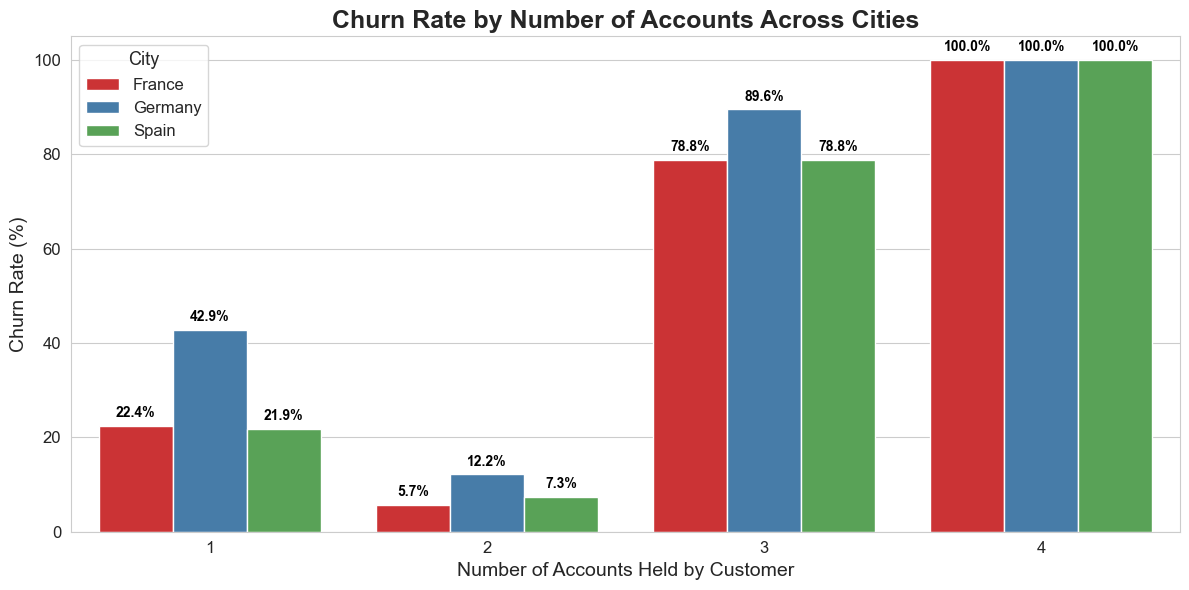

In [75]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=df,
    x='NumOfAccounts',
    y='churn_rate_percent',
    hue='City',
    palette='Set1'
)
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.1f%%', label_type='edge', padding=4, fontsize=10,fontweight='bold', color='black')

plt.title('Churn Rate by Number of Accounts Across Cities', fontsize=18, weight='bold')
plt.xlabel('Number of Accounts Held by Customer', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='City', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

# 10. Which customer traits affect whether they will leave the bank or stay, and do these traits make leaving more or less likely?

In [82]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

query = """ select * from churn_data """
cur.execute(query)
data = cur.fetchall()                               
columns = [desc[0] for desc in cur.description]     
df = pd.DataFrame(data, columns=columns)
df

,RowNumber,CustomerId,Surname,CreditScore,City,Gender,Age,TotalWork,Balance,NumofAccounts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101349.0,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543.0,0
2,3,15619304,Onio,502,France,Female,42,8,159661.0,3,1,0,113932.0,1
3,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125511.0,1,1,1,79084.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36,7,0.0,1,0,1,42085.6,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.3,2,1,0,92888.5,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.3,2,1,0,92888.5,1
10000,10000,15628319,Walker,792,France,Female,28,4,130143.0,1,1,0,38190.8,0


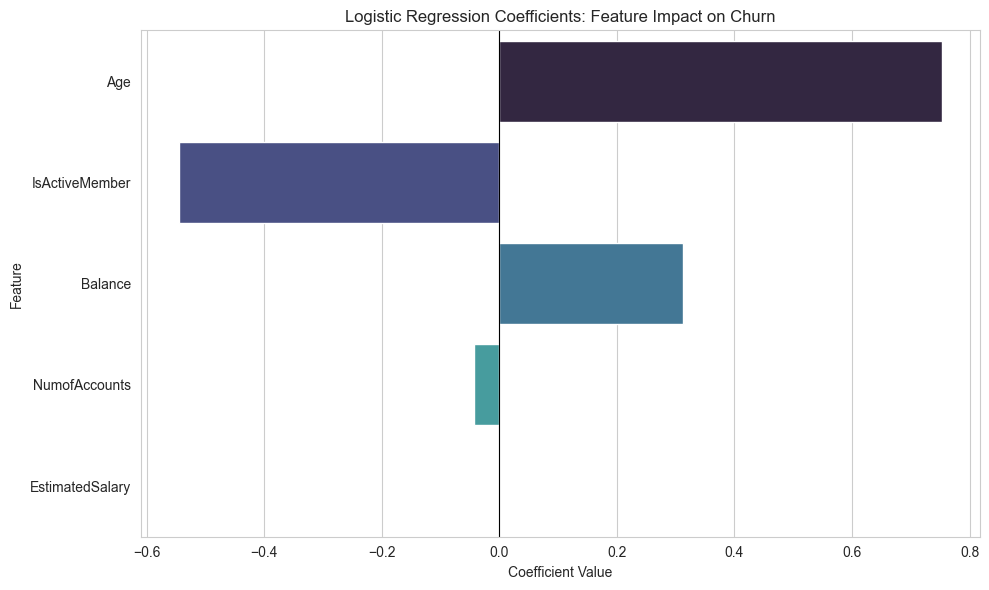

In [90]:
# Example feature columns (adjust based on your dataset)
features = ['Age', 'Balance', 'EstimatedSalary', 'NumofAccounts', 'IsActiveMember']
target = 'Exited'

# Prepare X and y
X = df[features]
y = df[target]


# Feature scaling for better logistic regression performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get coefficients and feature names
coefficients = model.coef_[0]
feature_names = features

# Create dataframe for visualization
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by absolute value of coefficient
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

# Plot coefficients
plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, hue='Feature', palette='mako', legend=False)
plt.title('Logistic Regression Coefficients: Feature Impact on Churn')
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## We built a logistic regression model to identify which features have the strongest impact on customer churn. The model estimates how each attribute affects the probability that a customer will leave (churn).

#### Positive coefficients mean that the feature increases the chance of churn.

#### Negative coefficients mean that the feature decreases the chance of churn.

#### The longer the bar, the stronger the impact.

## From the results:

#### Number of Accounts (NumofAccounts) has the biggest positive impact, suggesting customers with more accounts are more likely to churn.

#### IsActiveMember has a negative coefficient, indicating active members are less likely to churn.

#### Balance and Age also influence churn but less strongly.

#### This insight helps us prioritize which customers to target for retention efforts and what factors to monitor closely.

